# Goal : 

* Implement the **EfficientNets V2** from Scratch.
* Train it on [Cassava Leaf Disease Classification](https://www.kaggle.com/competitions/cassava-leaf-disease-classification).
* Compare the performance with standard PyTorch EfficientNets V2.

## Intution behind EfficientNet-V2:

* EfficientNets-V2 are optimized for **training speed** and parameter efficiency along with accuracy as compared to the EfficientNets-V1 which are optimzed for number of FLOPs and parameter efficiency.

* In EfficientNets-V1, as we move from version b1 to b7. we also uniformaly increase the image resolution according to the compound scaling method. This leads to increase in training time since batch size needs to be reduced in order to avoid Out of Memory (OOM) error in GPU. **EfficientNets-V2 handles this issue by slightly modifying the scaling rule and limiting the maximum image size to a smaller value.**

* In EfficientNets-V1, we have MBCONV Blocks which uses depthwise convolutions. According to the Author, Depthwise convolutions are slow in early layers but effective in later stages. Depthwise convolutions have fewer parameters and FLOPs than regular convolutions however they cannot fully utilize the modern accelarators. **EfficientNets-V2 uses Fused-MBCONV blocks in early layers to accelarate the training process**.


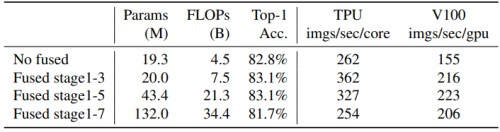

* EfficientNets-V2 uses the **non-uniform** scaling strategy as compared to the uniform scaling strategy of the EfficientNets-V1.

* According to the author, EfficientNets-V2 models trains much faster than state-of-the-art models while being up to 6.8x smaller.

## Additional Information:

**Fused MBCONV Block**:

* Same as MBCONV Block except the fact that Depthwise Convolution layer is replaced with normal Convolution layer.


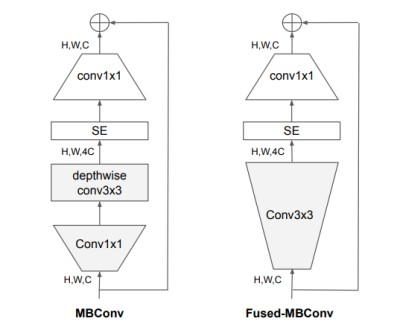

---------------------------------------------------------

**Progressive Learning**:

* According to the paper, The author hypothesized that low resolution images needs week regularizer and high resolution images requires strong regularizer while training to achieve the best accuracy. The author performed an experiment and results are as follows:

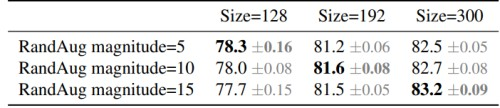

* The Progressive learning method is you start the training with small size images and weak augmentaions to learn the simpler features fast and easily first and then progressively increase the image size but also introduce the strong augmentations to make the learning difficult for the model. The augmentations used by the authors are **Dropout, RandAugment, and Mixup**.

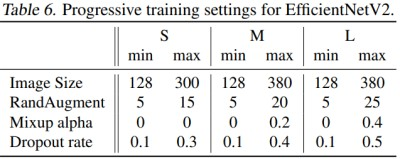

* The author has trained the various models with and without progressive learning under the same settings and proved that progressive learning provides the boost in model accuracy.


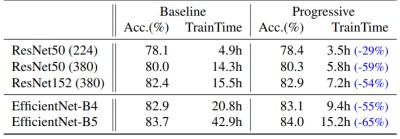

-------------------------------------------------------------------------------

## References:

* [Efficientnet-V1 Implementation From Scratch.](https://www.kaggle.com/code/vikramsandu/efficientnet-from-scratch)
* [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298.pdf)
* [EfficientNet from scratch in Pytorch by Aladdin Persson](https://www.youtube.com/watch?v=fR_0o25kigM)
* [Pytorch EfficientNet-V2](https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py)

In [1]:
# Import useful Modules
import torch
from torch import nn

In [2]:
Eff_V2_SETTINGS = {
    # expansion factor, k, stride, n_in, n_out, num_layers, use_fusedMBCONV
    's' : [
        [1, 3, 1, 24, 24, 2, True],
        [4, 3, 2, 24, 48, 4, True],
        [4, 3, 2, 48, 64, 4, True],
        [4, 3, 2, 64, 128, 6, False],
        [6, 3, 1, 128, 160, 9, False],
        [6, 3, 2, 160, 256, 15, False]
    ],
    
    'm' : [
        [1, 3, 1, 24, 24, 3, True],
        [4, 3, 2, 24, 48, 5, True],
        [4, 3, 2, 48, 80, 5, True],
        [4, 3, 2, 80, 160, 7, False],
        [6, 3, 1, 160, 176, 14, False],
        [6, 3, 2, 176, 304, 18, False],
        [6, 3, 1, 304, 512, 5, False]
    ],
    
    'l' : [
        [1, 3, 1, 32, 32, 4, True],
        [4, 3, 2, 32, 64, 7, True],
        [4, 3, 2, 64, 96, 7, True],
        [4, 3, 2, 96, 192, 10, False],
        [6, 3, 1, 192, 224, 19, False],
        [6, 3, 2, 224, 384, 25, False],
        [6, 3, 1, 384, 640, 7, False]
    ]
}

In [33]:
'''A simple Convolution + Batch Normalization + Activation Class'''

class ConvBnAct(nn.Module):
    
    def __init__(
        self,
        n_in, # in_channels
        n_out, # out_channels
        k_size = 3, # Kernel Size
        stride = 1, 
        padding = 0,
        groups = 1, 
        act = True, 
        bn = True, 
        bias = False
    ):
        super(ConvBnAct, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = k_size, stride = stride,
                              padding = padding, groups = groups,bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x
    
#--------------------------------------------------------------------------------------------

'''Squeeze and Excitation Class'''

class SqueezeExcitation(nn.Module):
    
    def __init__(
        self,
        n_in, # In_channels
        reduced_dim
    ):
        super(SqueezeExcitation, self).__init__()
      
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excite = nn.Sequential(nn.Conv2d(n_in, reduced_dim, kernel_size=1),
                                   nn.SiLU(),
                                   nn.Conv2d(reduced_dim, n_in, kernel_size=1),
                                   nn.Sigmoid()
                                   )
        
    def forward(self, x):
        y = self.squeeze(x)
        y = self.excite(y)
            
        return x * y
        
#--------------------------------------------------------------------------------------

''' Stochastic Depth Class'''

class StochasticDepth(nn.Module):
    
    def __init__(
        self,
        survival_prob = 0.8
    ):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):
        
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        
        return torch.div(x, self.p) * binary_tensor
        
#-------------------------------------------------------------------------------

'''MBCONV Class'''

class MBConvN(nn.Module):
    
    def __init__(
        self,
        n_in, # In_channels
        n_out, # out_channels
        k_size = 3, # kernel_size
        stride = 1,
        expansion_factor = 4,
        reduction_factor = 4, # SqueezeExcitation Block
        survival_prob = 0.8 # StochasticDepth Block
    ):
        super(MBConvN, self).__init__()
        reduced_dim = int(n_in//4)
        expanded_dim = int(expansion_factor * n_in)
        padding = (k_size - 1)//2
        
        self.use_residual = (n_in == n_out) and (stride == 1)
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded_dim, k_size = 1)
        self.depthwise_conv = ConvBnAct(expanded_dim, expanded_dim,
                                        k_size, stride = stride,
                                        padding = padding, groups = expanded_dim
                                       )
        self.se = SqueezeExcitation(expanded_dim, reduced_dim)
        self.drop_layers = StochasticDepth(survival_prob)
        self.pointwise_conv = ConvBnAct(expanded_dim, n_out, k_size = 1, act = False)
        
    def forward(self, x):
        
        residual = x.clone()
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.use_residual:
            x = self.drop_layers(x)
            x += residual
            
        return x
    
#--------------------------------------------------------------------------------------

'''Fused-MBCONV Class'''

class FusedMBConvN(nn.Module):
    
    def __init__(
        self,
        n_in, # In_channels
        n_out, # out_channels
        k_size = 3, # kernel_size
        stride = 1,
        expansion_factor = 4,
        reduction_factor = 4, # SqueezeExcitation Block
        survival_prob = 0.8 # StochasticDepth Block
    ):
        super(FusedMBConvN, self).__init__()
        
        reduced_dim = int(n_in//4)
        expanded_dim = int(expansion_factor * n_in)
        padding = (k_size - 1)//2
        
        self.use_residual = (n_in == n_out) and (stride == 1)
        #self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, expanded_dim, k_size = 1)
        self.conv = ConvBnAct(n_in, expanded_dim,
                              k_size, stride = stride,
                              padding = padding, groups = 1
                             )
        #self.se = SqueezeExcitation(expanded_dim, reduced_dim)
        self.drop_layers = StochasticDepth(survival_prob)
        self.pointwise_conv = nn.Identity() if (expansion_factor == 1) else ConvBnAct(expanded_dim, n_out, k_size = 1, act = False)
        
    def forward(self, x):
        
        residual = x.clone()
        #x = self.conv(x)
        x = self.conv(x)
        #x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.use_residual:
            x = self.drop_layers(x)
            x += residual
            
        return x
    
#-----------------------------------------------------------------------------------------------

class EfficientNetV2(nn.Module):
    
    def __init__(
    self,
    version = 's',
    dropout_rate = 0.2,
    num_classes = 1000
    ):
        super(EfficientNetV2, self).__init__()
        last_channel = 1280
        self.features = self._feature_extractor(version, last_channel)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(dropout_rate, inplace = True),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        
        return x
        
    def _feature_extractor(self, version, last_channel):
        
        # Extract the Config
        config = Eff_V2_SETTINGS[version]
        
        layers = []
        layers.append(ConvBnAct(3, config[0][3], k_size = 3, stride = 2, padding = 1))
        #in_channel = config[0][3]
        
        for (expansion_factor, k, stride, n_in, n_out, num_layers, use_fused) in config:
            
            if use_fused:
                layers += [FusedMBConvN(n_in if repeat==0 else n_out, 
                                        n_out,
                                        k_size=k,
                                        stride = stride if repeat==0 else 1,
                                        expansion_factor=expansion_factor
                                       ) for repeat in range(num_layers)
                          ]
            else:
                
                layers += [MBConvN(n_in if repeat==0 else n_out, 
                                   n_out,
                                   k_size=k,
                                   stride = stride if repeat==0 else 1,
                                   expansion_factor=expansion_factor
                                   ) for repeat in range(num_layers)
                      ]
                
        layers.append(ConvBnAct(config[-1][4], last_channel, k_size = 1))   
            
        return nn.Sequential(*layers)

In [34]:
def test(version = 's', num_classes = 1000):
    net = EfficientNetV2(version = version, num_classes = num_classes)
    x = torch.rand(4, 3, 224, 224)
    y = net(x)
    print(y.size())
    
test()

torch.Size([4, 1000])


# [Cassava Leaf Disease Classification](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data?select=train.csv)

In [5]:
# Useful Imports
import os, random
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import json

In [6]:
DATA_DIR = '../input/cassava-leaf-disease-classification'

# Reading the labels.
f = open(os.path.join(DATA_DIR, 'label_num_to_disease_map.json'))
  
# returns JSON object as 
# a dictionary
labels = json.load(f)
  
# Iterating through the json
# list
labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [7]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

df['disease'] = df['label'].apply(lambda x : labels[str(x)])
df.tail()

,image_id,label,disease
21392,999068805.jpg,3,Cassava Mosaic Disease (CMD)
21393,999329392.jpg,3,Cassava Mosaic Disease (CMD)
21394,999474432.jpg,1,Cassava Brown Streak Disease (CBSD)
21395,999616605.jpg,4,Healthy
21396,999998473.jpg,4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='disease', ylabel='count'>

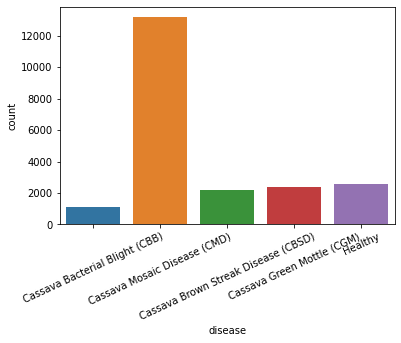

In [8]:
import seaborn as sns

plt.xticks(rotation=25)
sns.countplot(df['disease'])

## Helper functions

In [9]:
from torch.utils.data import Dataset
from PIL import Image

# Dataset Class
class CassavaLeafDataset(Dataset):
    
    def __init__(self, data_path, metadata_csv, transform = None):
        super(CassavaLeafDataset, self).__init__()
        
        self.df = metadata_csv #pd.read_csv(metadata_csv_path)
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = self.df['image_id'].iloc[index]
        class_label = torch.tensor(int(self.df['label'].iloc[index]))
        
        img = Image.open(os.path.join(self.data_path, img_name))
        
        if self.transform is not None:
            img = self.transform(img)
            
        return (img, class_label)
    
#------------------------------------------------------------------------------------------

import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (12, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
#-----------------------------------------------------------------------------------------

# Model Performance on test data
def calculate_loss_and_accuracy(model, dataloader, size_of_dataset, criterion):
    
    # Now set model to validation mode.
    running_loss = 0
    running_accuracy = 0
    
     # Processing the Test Loader
    for (inputs, labels) in dataloader:
        
        # Load data to device.
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Loss and Backpropagation.
        loss = criterion(outputs, labels)
        
        # Statistics
        running_loss += loss.item()*inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss/size_of_dataset
    epoch_accuracy = running_accuracy/size_of_dataset
    
    return epoch_loss, epoch_accuracy

#------------------------------------------------------------------------------------------------
import copy

def train(model, criterion, optimizer, scheduler, num_of_epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #track_training_loss = []
    #track_val_loss = []

    for epoch in range(num_of_epochs):

        print(f'\nEpoch {epoch + 1}/{num_of_epochs}')
        print('-'*30)

        model.train() # Setting model to train.
        running_loss = 0
        running_accuracy = 0

        # Processing the Train Loader
        for (inputs, labels) in train_loader:

            # Load data to device.
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients

            # Outputs
            outputs = model(inputs)
            _ , preds = torch.max(outputs, 1)

            # Loss and Backpropagation.
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()*inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
        
        scheduler.step()
        epoch_loss = running_loss/len(train_dataset)
        epoch_accuracy = running_accuracy/len(train_dataset)
        #track_training_loss.append(epoch_loss) # Loss Tracking

        print(f'Training Loss: {epoch_loss:.4f} Training Acc.: {epoch_accuracy:.4f}')

        # Now set model to validation mode.
        model.eval()

        val_loss, val_accuracy = calculate_loss_and_accuracy(model, val_loader, len(val_dataset), criterion)

        if val_accuracy > best_acc:
            print("Found better model...")
            print('Updating the model weights....\n')
            print(f'Val Loss: {val_loss:.4f} Val Acc.: {val_accuracy:.4f}\n')

            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
     
    model.load_state_dict(best_model_wts) # update model
    
    return  model

## Data Preparation

In [10]:
# Divide the data into training and validation (80-20 split for each category)
train_df = pd.DataFrame(columns = ['image_id', 'label'])
val_df = pd.DataFrame(columns = ['image_id', 'label'])

for label in df['label'].unique():
    temp_df = df[df['label'] == label].reset_index(drop = True)
    num_of_train_data = len(temp_df)*80//100
    train_df = train_df.append(temp_df.iloc[0:num_of_train_data].reset_index(drop=True), ignore_index = True)
    val_df = val_df.append(temp_df.iloc[num_of_train_data:].reset_index(drop=True), ignore_index = True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


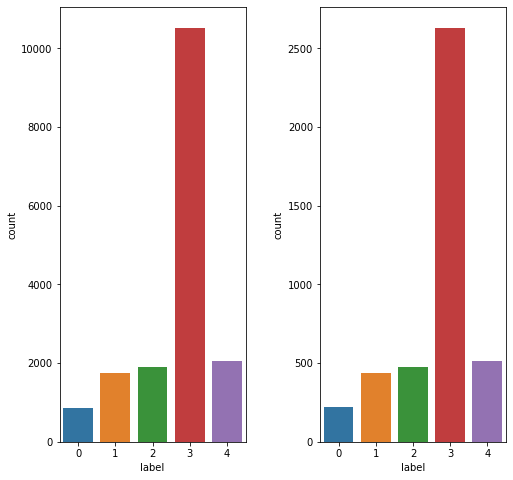

In [11]:
# Train and Valid Data Distribution
fig, ax =plt.subplots(1,2, figsize=(8, 8))
sns.countplot(train_df['label'], ax=ax[0])
sns.countplot(val_df['label'], ax=ax[1])

# set the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [12]:
# Dataset and Dataloaders.
# Hyper-params
BATCH_SIZE = 16
NUM_OF_CLASSES = 5
device = torch.device('cuda')

# Data Prepration.
from torchvision import transforms
from torch.utils.data import DataLoader

# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Datasets
train_dataset = CassavaLeafDataset(os.path.join(DATA_DIR, 'train_images'), train_df, data_transforms['train'])
val_dataset = CassavaLeafDataset(os.path.join(DATA_DIR, 'train_images'), val_df, data_transforms['val'])


# Datloaders
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = False)

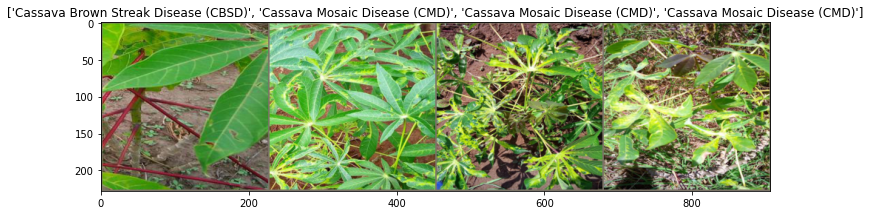

In [13]:
# Visualization
data_loader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True)
inputs, classes = next(iter(data_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[labels[str(x.item())] for x in classes])

## Standard Pytorch Efficient-net

In [21]:
# Pytorch Standard Resnet-18 Model.
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim

model = torch.hub.load('hankyul2/EfficientNetV2-pytorch', 'efficientnet_v2_s', pretrained=False, dropout=0.2, stochastic_depth=0.0)

# Set num of classes to 5
model.head.classifier = nn.Linear(1280, NUM_OF_CLASSES, bias = True)

model = model.to(device) # Load model to device.

# Criterion.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

NUM_OF_EPOCHS = 10

# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )

Using cache found in /root/.cache/torch/hub/hankyul2_EfficientNetV2-pytorch_main



Epoch 1/10
------------------------------
Training Loss: 1.0987 Training Acc.: 0.6197
Found better model...
Updating the model weights....

Val Loss: 2.2144 Val Acc.: 0.6305


Epoch 2/10
------------------------------
Training Loss: 0.9833 Training Acc.: 0.6355
Found better model...
Updating the model weights....

Val Loss: 1.0807 Val Acc.: 0.6625


Epoch 3/10
------------------------------
Training Loss: 0.9149 Training Acc.: 0.6575
Found better model...
Updating the model weights....

Val Loss: 2.1097 Val Acc.: 0.6735


Epoch 4/10
------------------------------
Training Loss: 0.8654 Training Acc.: 0.6708
Found better model...
Updating the model weights....

Val Loss: 0.8955 Val Acc.: 0.6782


Epoch 5/10
------------------------------
Training Loss: 0.8300 Training Acc.: 0.6872
Found better model...
Updating the model weights....

Val Loss: 0.8841 Val Acc.: 0.6899


Epoch 6/10
------------------------------
Training Loss: 0.7709 Training Acc.: 0.7074
Found better model...
Updating th

## Our EfficientNet-V2 Training

In [36]:
# Pytorch Standard Resnet-18 Model.
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim

# Initialize Efficientnet model
version = 's'
model = EfficientNetV2(version = version, dropout_rate = 0.2, num_classes = NUM_OF_CLASSES)
model = model.to(device) # Load model to device.


# Criterion.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

NUM_OF_EPOCHS = 10

# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )


Epoch 1/10
------------------------------
Training Loss: 1.2074 Training Acc.: 0.6108
Found better model...
Updating the model weights....

Val Loss: 1.1197 Val Acc.: 0.6198


Epoch 2/10
------------------------------
Training Loss: 1.1247 Training Acc.: 0.6140

Epoch 3/10
------------------------------
Training Loss: 1.0572 Training Acc.: 0.6258
Found better model...
Updating the model weights....

Val Loss: 0.9817 Val Acc.: 0.6434


Epoch 4/10
------------------------------
Training Loss: 1.0260 Training Acc.: 0.6277
Found better model...
Updating the model weights....

Val Loss: 0.9278 Val Acc.: 0.6443


Epoch 5/10
------------------------------
Training Loss: 0.9897 Training Acc.: 0.6359
Found better model...
Updating the model weights....

Val Loss: 0.8855 Val Acc.: 0.6649


Epoch 6/10
------------------------------
Training Loss: 0.9417 Training Acc.: 0.6488
Found better model...
Updating the model weights....

Val Loss: 0.8654 Val Acc.: 0.6719


Epoch 7/10
---------------------

# Comparison:

**Pytorch Standard EffnetV2-s**:

* Validation Accuracy: **0.7480**


**Our EffnetV2-s**:

* Validation Accuracy: **0.6766**

---------------------------------------------------------------------